# ARIMA Model with Python

 AutoRegressive Integrated Moving Average. It is a class of models that captures a suite of different standard temporal structures in time series data.

# IMPORT

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
# warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


# Dataset
**Minimum Daily Temperatures Dataset**

Use the following dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia. The source of the data is credited as the Australian Bureau of Meteorology.
The units are in degrees Celsius and there are 3,650 observations.

Download the dataset here:  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

**Load the dataset and create a line plot of the time series**

In [3]:
import requests
import os
import pandas as pd

def telecharger_et_charger_fichier(url, dossier_destination=None):
    """
    Télécharge un fichier depuis une URL donnée, le sauvegarde dans un dossier spécifié,
    Si le dossier n'existe pas il est crée
    Par defaut enregistre le fichier dans un repertoire ../datas qui est à la racine du projet
    et charge le fichier dans un DataFrame en fonction de son format.

    :param url: URL du fichier à télécharger.
    :param dossier_destination: Dossier de destination optionnel pour le fichier.
    :return: Tuple contenant le DataFrame original, sa copie, et le nom du fichier.
    """
    # Initialiser df_original et df à None
    df_original, df = None, None
    try:
        # Déterminer le nom du fichier à partir de l'URL
        nom_fichier = url.split('/')[-1]

        # Construire le chemin absolu du dossier de destination
        if dossier_destination is None:
            # Chemin par défaut relatif au script
            chemin_script = os.path.dirname(os.path.abspath(__file__))
            chemin_complet = os.path.join(chemin_script, "..", "datas", nom_fichier)
        else:
            # Utiliser le chemin de destination fourni
            chemin_complet = os.path.join(dossier_destination, nom_fichier)

        # Créer le dossier de destination s'il n'existe pas
        os.makedirs(os.path.dirname(chemin_complet), exist_ok=True)

        # Télécharger le fichier
        response = requests.get(url)
        response.raise_for_status()

        # Écrire le contenu dans le fichier de destination
        with open(chemin_complet, 'wb') as file:
            file.write(response.content)

        # Déterminer l'extension du fichier et charger dans un DataFrame
        extension = nom_fichier.split('.')[-1].lower()
        if extension in ['csv', 'txt']:
            df_original = pd.read_csv(chemin_complet, encoding='utf-8')
        elif extension == 'json':
            df_original = pd.read_json(chemin_complet, encoding='utf-8', orient='records')
        elif extension == 'xlsx':
            df_original = pd.read_excel(chemin_complet, index_col=0)
        else:
            print(f"Format de fichier non pris en charge : {extension}")

        # Faire une copie du DataFrame si celui-ci a été chargé
        if df_original is not None:
            df = df_original.copy()

        return df_original, df, chemin_complet

    except requests.HTTPError as http_err:
        print(f"Erreur HTTP lors du téléchargement du fichier : {http_err}")
        return None, None, None
    except Exception as err:
        print(f"Une erreur est survenue lors du téléchargement du fichier : {err}")
        return None, None, None



In [4]:
# Chargement du df
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
# df_original, df, nom_fichier = telecharger_et_charger_csv(url)
df_original, df, nom_fichier = telecharger_et_charger_fichier( url, "datas/csv")


In [36]:
df=df_original.copy()


In [ ]:
df.describe


In [ ]:
df.columns.tolist()


In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [9]:
# import matplotlib.pyplot as plt

# def our_date_parser(x):
#     return pd.datetime.strptime('190'+x, '%Y-%m')

# shamp_series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', index_col='Month', parse_dates=True, date_parser=our_date_parser)


In [10]:
# df['date']=pd.to_datetime(df['Month'],infer_datetime_format=True)


# Split the dataset

Split the dataset into 2 subsets. The first part will be the training dataset that you will use to build an ARIMA model. The second part is the test dataset. It is these time steps that you will treat as out-of-sample.

Write the code to load the dataset, split it into the training and validation datasets, and save them to files *dataset.csv* and *validation.csv* respectively.


**Instructions**

The dataset contains data from January 1st 1981 to December 31st 1990.
Hold back the last 7 days of the dataset from December 1990 as the test dataset and treat those time steps as out of sample.

Specifically 1990-12-25 to 1990-12-31

In [37]:
# En supposant que df est votre DataFrame original
from datetime import datetime

df=df_original.copy()
# Convertir l'index en datetime si ce n'est pas déjà le cas
df.Date = pd.to_datetime(df.Date)
#  colonne date en index
df.set_index('Date', inplace=True)

# Diviser le jeu de données
train_df = df[df.index < '1990-12-25']
test_df = df[df.index >= '1990-12-25']

# Enregistrer dans des fichiers
train_df.to_csv('dataset.csv', encoding='utf-8')
test_df.to_csv('validation.csv', encoding='utf-8')


In [38]:
train_df


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-20,15.4
1990-12-21,13.1
1990-12-22,13.2


In [39]:
test_df


,Temp
Date,
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


# Build the model
Check if the data is stationary. If it is not, make it stationary and develop a simple ARIMA model.

Résultats du test de Dickey-Fuller :
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


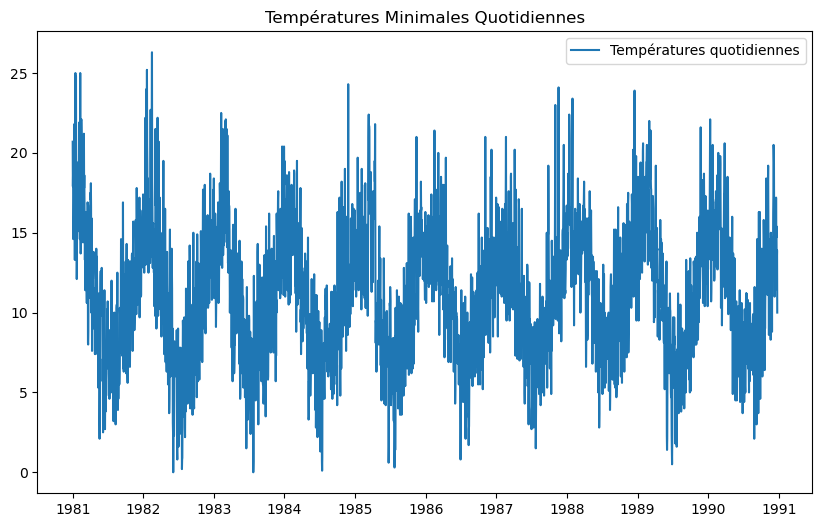

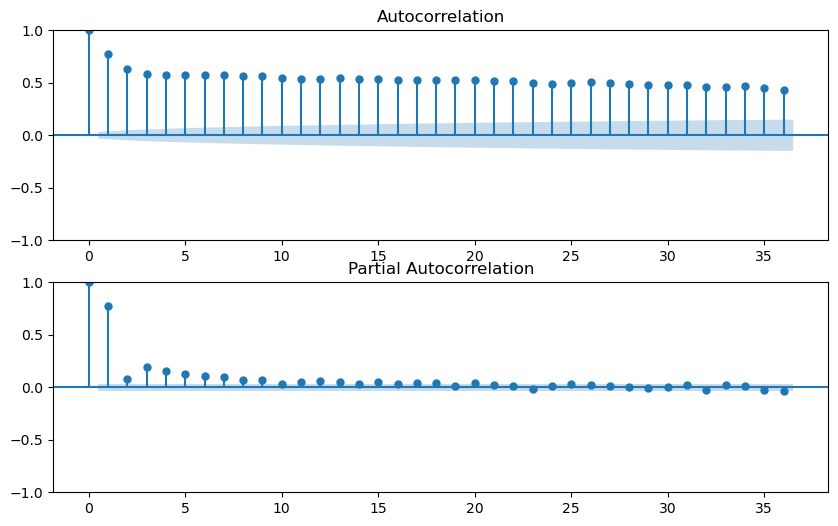

Résultats du test de Dickey-Fuller :
Test Statistic                -1.798113e+01
p-value                        2.774575e-30
#Lags Used                     2.400000e+01
Number of Observations Used    3.617000e+03
Critical Value (1%)           -3.432159e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567196e+00
dtype: float64


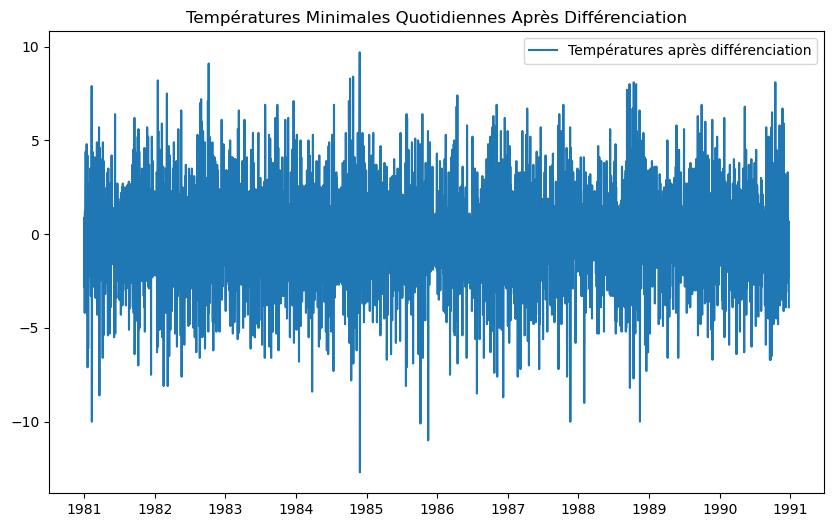

In [40]:
# Your code here
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

serie_temporelle = train_df['Temp']

# Test de stationnarité avec ADF
def test_stationarity(timeseries):
    print('Résultats du test de Dickey-Fuller :')
    train_df = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(train_df[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in train_df[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Appel de la fonction test_stationarity sur vos données
test_stationarity(df['Temp'])

# Visualisation de la série temporelle
plt.figure(figsize=(10, 6))
plt.plot(train_df['Temp'], label='Températures quotidiennes')
plt.title('Températures Minimales Quotidiennes')
plt.legend()
plt.show()

# Visualisation de l'autocorrélation et de l'autocorrélation partielle
fig, ax = plt.subplots(2, figsize=(10, 6))
plot_acf(train_df['Temp'], ax=ax[0])
plot_pacf(train_df['Temp'], ax=ax[1])
plt.show()

# Différenciation pour rendre la série stationnaire
df_diff = train_df['Temp'].diff().dropna()

# Test de stationnarité après différenciation
test_stationarity(df_diff)

# Visualisation de la série différenciée
plt.figure(figsize=(10, 6))
plt.plot(df_diff, label='Températures après différenciation')
plt.title('Températures Minimales Quotidiennes Après Différenciation')
plt.legend()
plt.show()


# One-step out-of-sample forecast
A one-step forecast is a forecast of the very next time step in the sequence from the available data used to fit the model.

In this case, we are interested in a one-step forecast of Christmas Day 1990: 1990-12-25

**Instructions**
The statsmodel `ARIMAResults` object provides a `forecast()` function for making predictions.

By default, this function makes a single step out-of-sample forecast. As such, you can call it directly and make your forecast. The result of the `forecast()` function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. You are only interested in the first element of this forecast.

**Expected result: **
`Forecast: 14.861669`

In [29]:
train_df


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3638,1990-12-20,15.4
3639,1990-12-21,13.1
3640,1990-12-22,13.2
3641,1990-12-23,13.9


In [41]:
# Supposons que nous ayons identifié que p=5, d=1, q=2 sont de bons paramètres après analyse
# Construction et ajustement du modèle ARIMA

model = ARIMA(serie_temporelle, order=(5, 1, 2))
model_fit = model.fit()

# Prévisions
train_df['Forecast'] = model_fit.predict(start=pd.to_datetime('1990-12-25'), dynamic=False)

# Visualisation des prévisions
plt.figure(figsize=(12, 5))
plt.plot(serie_temporelle, label='Température Réelle')
plt.plot(train_df['Forecast'], label='Prévision')
plt.title('Prévision de la Température Minimale Quotidienne')
plt.legend()
plt.show()


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

On ne peut pas créer de pipeline pour tester différents modèles ARIMA avec un GridSearchCV car il n'est pas implementé dans scikit-learn, ARIMA n'est pas un modèle scikit-learn 

Les données de séries temporelles ne peuvent pas être mélangées de manière aléatoire comme le fait un GridSearchCV classique pour les données de validation croisée.

D'où une recherche d'optimisation à l'aide d'une boucle

In [ ]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tqdm import tqdm
# # Charger les données
# # df = pd.read_csv('chemin_du_fichier.csv', index_col='Date', parse_dates=True)
# serie_temporelle = train_df['Temp']

# # Préparer les données de train et de test
# train_size = int(len(serie_temporelle) * 0.8)
# train, test = serie_temporelle[0:train_size], serie_temporelle[train_size:]

# # Grid search des paramètres ARIMA
# meilleur_score, meilleurs_parametres = float("inf"), None
# for p in tqdm(range(5)):  # Étendue des valeurs de 'p'
#     for d in range(3):  # Étendue des valeurs de 'd'
#         for q in range(5):  # Étendue des valeurs de 'q'
#             order = (p, d, q)
#             try:
#                 model = ARIMA(train, order=order)
#                 model_fit = model.fit()
#                 predictions = model_fit.forecast(steps=len(test))

#                 mse = mean_squared_error(test, predictions)
#                 mape = mean_absolute_percentage_error(test, predictions)
#                 mae = mean_absolute_error(test, predictions)

#                 if mse < meilleur_score:
#                     meilleur_score, meilleurs_parametres = mse, order
#                     meilleur_mape, meilleur_mae = mape, mae

#                 print(f'ARIMA{order} - MSE: {mse:.3f}, MAPE: {mape:.3f}, MAE: {mae:.3f}')
#             except:
#                 continue

# print(f'Meilleur modèle ARIMA{meilleurs_parametres} - MSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.3f}, MAE: {meilleur_mae:.3f}')


In [ ]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tqdm import tqdm
# import time

# # Fonction pour calculer le MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




# def arima_optimisation(serie_temporelle, X_train, y_test):
#     # # Préparer les données de train et de test
#     # train_size = int(len(serie_temporelle) * 0.8)
#     # train, test = serie_temporelle[0:train_size], serie_temporelle[train_size:]

#     # Grid search des paramètres ARIMA
#     meilleur_score, meilleurs_parametres = float("inf"), None
#     meilleur_mape, meilleur_mae = float("inf"), float("inf")

#     for p in range(5):  # Étendue des valeurs de 'p'
#         for d in range(3):  # Étendue des valeurs de 'd'
#             for q in range(5):  # Étendue des valeurs de 'q'
#                 order = (p, d, q)
#                 try:
#                     model = ARIMA(train, order=order)
#                     model_fit = model.fit()
#                     predictions = model_fit.forecast(steps=len(test))

#                     mse = mean_squared_error(test, predictions)
#                     mape = mean_absolute_percentage_error(test, predictions)
#                     mae = mean_absolute_error(test, predictions)

#                     if mse < meilleur_score:
#                         meilleur_score, meilleurs_parametres = mse, order
#                         meilleur_mape, meilleur_mae = mape, mae

#                     print(f'ARIMA{order} - MSE: {mse:.3f}, MAPE: {mape:.3f}, MAE: {mae:.3f}')
#                 except:
#                     continue
#     yield p
#     return meilleur_score, meilleurs_parametres,meilleur_mape,meilleur_mae

# print(f'Meilleur modèle ARIMA{meilleurs_parametres} - MSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.3f}, MAE: {meilleur_mae:.3f}')

# # test
# colonne_temperature = train_df['Temp']
# # X_train=train_df
# meilleur_score, meilleurs_parametres,meilleur_mape,meilleur_mae=tqdm(arima_optimisation(colonne_temperature, train_df, test_df))


In [ ]:
# import numpy as np
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tqdm.notebook import tqdm
# import time
# import psutil
# import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# # Fonction pour calculer le MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     non_zero_index = (y_true != 0)
#     return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

# def arima_optimisation(train, test, p_values, d_values, q_values):
#     meilleur_score, meilleurs_parametres = float("inf"), None
#     meilleur_mape, meilleur_mae = float("inf"), float("inf")

#     total_iterations = len(p_values) * len(d_values) * len(q_values)
#     start_time = time.time()

#     for p in tqdm(p_values, desc='Total Progress'):
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 try:
#                     model = ARIMA(train, order=order)
#                     model_fit = model.fit(maxiter=200)
#                     predictions = model_fit.forecast(steps=len(test))

#                     mse = mean_squared_error(test, predictions)
#                     mape = mean_absolute_percentage_error(test, predictions)
#                     mae = mean_absolute_error(test, predictions)

#                     if mse < meilleur_score:
#                         meilleur_score, meilleurs_parametres = mse, order
#                         meilleur_mape, meilleur_mae = mape, mae

#                 except:
#                     continue
#     execution_time = time.time() - start_time
#     memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # Memory usage in MB
#     cpu_usage = psutil.cpu_percent()

#     print(f'Execution time: {execution_time:.2f}s')
#     print(f'Memory usage: {memory_usage:.2f} MB')
#     print(f'CPU usage: {cpu_usage}%')

#     return meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae

# # Paramètres pour le Grid Search
# p_values = range(5)
# d_values = range(3)
# q_values = range(5)

# # Appel de la fonction d'optimisation ARIMA
# meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae = arima_optimisation(
#     train_df['Temp'],
#     test_df['Temp'],
#     p_values,
#     d_values,
#     q_values
# )

# print(f'Meilleur modèle ARIMA{meilleurs_parametres} - MSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.3f}, MAE: {meilleur_mae:.3f}')


In [ ]:
# import numpy as np
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tqdm.notebook import tqdm
# import time
# import psutil
# import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# # Fonction pour calculer le MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     non_zero_index = (y_true != 0)
#     return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

# def arima_optimisation(train, test, p_values, d_values, q_values):
#     meilleur_score, meilleurs_parametres = float("inf"), None
#     meilleur_mape, meilleur_mae = float("inf"), float("inf")

#     total_iterations = len(p_values) * len(d_values) * len(q_values)
#     start_time = time.time()

#     for p in tqdm(p_values, desc='Total Progress'):
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 try:
#                     with warnings.catch_warnings():
#                         warnings.simplefilter("ignore", category=ConvergenceWarning)
#                         model = ARIMA(train, order=order)
#                         model_fit = model.fit(maxiter=500)
#                         predictions = model_fit.forecast(steps=len(test))

#                         mse = mean_squared_error(test, predictions)
#                         mape = mean_absolute_percentage_error(test, predictions)
#                         mae = mean_absolute_error(test, predictions)

#                         if mse < meilleur_score:
#                             meilleur_score, meilleurs_parametres = mse, order
#                             meilleur_mape, meilleur_mae = mape, mae

#                 except:
#                     continue

#     execution_time = time.time() - start_time
#     memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # Memory usage in MB
#     cpu_usage = psutil.cpu_percent()

#     print(f'Execution time: {execution_time:.2f}s')
#     print(f'Memory usage: {memory_usage:.2f} MB')
#     print(f'CPU usage: {cpu_usage}%')

#     return meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae

# # Paramètres pour le Grid Search
# p_values = range(5)
# d_values = range(3)
# q_values = range(5)

# # Appel de la fonction d'optimisation ARIMA
# meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae = arima_optimisation(
#     train_df['Temp'],
#     test_df['Temp'],
#     p_values,
#     d_values,
#     q_values
# )

# print(f'Meilleur modèle ARIMA {"-"*50} ={meilleurs_parametres} - MSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.3f}, MAE: {meilleur_mae:.3f}')


In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
import time
import psutil
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", ValueWarning)

# Fonction pour calculer le MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

def arima_optimisation(train, test, p_values, d_values, q_values):
    meilleur_score, meilleurs_parametres = float("inf"), None
    meilleur_mape, meilleur_mae = float("inf"), float("inf")

    total_iterations = len(p_values) * len(d_values) * len(q_values)
    start_time = time.time()

    for p in tqdm(p_values, desc='Total Progress'):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)
                        model = ARIMA(train, order=order)
                        model_fit = model.fit()
                        predictions = model_fit.forecast(steps=len(test))

                        mse = mean_squared_error(test, predictions)
                        mape = mean_absolute_percentage_error(test, predictions)
                        mae = mean_absolute_error(test, predictions)

                        if mse < meilleur_score:
                            meilleur_score, meilleurs_parametres = mse, order
                            meilleur_mape, meilleur_mae = mape, mae

                except Exception as e:
                    print(f"Erreur pour ARIMA{order}: {e}")
                    continue

    execution_time = time.time() - start_time
    memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # Memory usage in MB
    cpu_usage = psutil.cpu_percent()

    print(f'Execution time: {execution_time:.2f}s')
    print(f'Memory usage: {memory_usage:.2f} MB')
    print(f'CPU usage: {cpu_usage}%')

    return meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae

# Paramètres pour le Grid Search
p_values = range(4)
d_values = range(4)
q_values = range(8)

# Appel de la fonction d'optimisation ARIMA
meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae = arima_optimisation(
    train_df['Temp'],
    test_df['Temp'],
    p_values,
    d_values,
    q_values
)

print(f'Meilleur modèle ARIMA{meilleurs_parametres} - MSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.3f}, MAE: {meilleur_mae:.3f}')



Total Progress:   0%|          | 0/4 [00:00<?, ?it/s]

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\state

Execution time: 313.57s
Memory usage: 405.61 MB
CPU usage: 22.8%
Meilleur modèle ARIMA(0, 3, 4) - MSE: 0.751, MAPE: 5.149, MAE: 0.724


In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
import time
import psutil
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", ValueWarning)

# Fonction pour calculer le MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

def arima_optimisation(train, test, p_values, d_values, q_values):
    meilleur_score, meilleurs_parametres = float("inf"), None
    meilleur_mape, meilleur_mae = float("inf"), float("inf")

    total_iterations = len(p_values) * len(d_values) * len(q_values)
    start_time = time.time()

    with tqdm(total=total_iterations, desc='Total Progress') as pbar:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p, d, q)
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=ConvergenceWarning)
                            model = ARIMA(train, order=order)
                            model_fit = model.fit()
                            predictions = model_fit.forecast(steps=len(test))

                            mse = mean_squared_error(test, predictions)
                            mape = mean_absolute_percentage_error(test, predictions)
                            mae = mean_absolute_error(test, predictions)

                            if mse < meilleur_score:
                                meilleur_score, meilleurs_parametres = mse, order
                                meilleur_mape, meilleur_mae = mape, mae

                    except Exception as e:
                        print(f"Erreur pour ARIMA{order}: {e}")
                        continue
                    finally:
                        # Mise à jour de la barre de progression après chaque itération
                        pbar.update(1)

    execution_time = time.time() - start_time
    memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # Memory usage in MB
    cpu_usage = psutil.cpu_percent()

    print(f'Execution time: {execution_time:.2f}s')
    print(f'Memory usage: {memory_usage:.2f} MB')
    print(f'CPU usage: {cpu_usage}%')

    return meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae


In [42]:
# Paramètres pour le Grid Search
p_values = range(4)
d_values = range(4)
q_values = range(8)

# Appel de la fonction d'optimisation ARIMA
meilleur_score, meilleurs_parametres, meilleur_mape, meilleur_mae = arima_optimisation(
    train_df['Temp'],
    test_df['Temp'],
    p_values,
    d_values,
    q_values
)

print(f'Meilleur modèle ARIMA {"-"*50} = {meilleurs_parametres} - \nMSE: {meilleur_score:.3f}, MAPE: {meilleur_mape:.2%}°, MAE: {meilleur_mae:.3f}')
# Execution time: 313.92s
# Memory usage: 358.05 MB
# CPU usage: 25.3%
# Meilleur modèle ARIMA ["-"*50]= (0, 3, 4) - MSE: 75.082%, MAPE: 5.149, MAE: 72.441%


Total Progress:   0%|          | 0/128 [00:00<?, ?it/s]

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supp

Le meilleur modèle ARIMA  a les paramètres (0, 3, 4) 

- **ARIMA(0, 3, 4)** : C'est mon modèle ARIMA utilisé. Les paramètres du modèle ARIMA sont généralement notés (p, d, q), où :
    - `p` est l'ordre de la partie autorégressive (AR) du modèle.
    - `d` est le nombre de différenciations nécessaires pour rendre la série temporelle stationnaire.
    - `q` est l'ordre de la partie moyenne mobile (MA) du modèle.
  Dans mon cas, `p=0`, `d=3`, et `q=4`.

- **MSE: 75.082%** : Le Mean Squared Error (MSE) est une mesure de l'erreur de prédiction du modèle. Il est calculé comme la moyenne des carrés des erreurs entre les prédictions et les vraies valeurs. Un MSE de 75.082% est assez élevé, ce qui suggère que le modèle a une erreur de prédiction significative.

- **MAPE: 5.149** : Le Mean Absolute Percentage Error (MAPE) est une autre mesure de l'erreur de prédiction du modèle. Il est calculé comme la moyenne des valeurs absolues des erreurs en pourcentage. Un MAPE de 5.149 signifie que, en moyenne, les prédictions du modèle sont à environ 5.149% de la valeur réelle.

- **MAE: 72.441%** : Le Mean Absolute Error (MAE) est une mesure de l'erreur de prédiction du modèle. Il est calculé comme la moyenne des valeurs absolues des erreurs. Un MAE de 72.441% est également assez élevé, ce qui suggère que le modèle a une erreur de prédiction significative.

En résumé, ces résultats indiquent que le modèle ARIMA(0, 3, 4) a une erreur de prédiction significative. Vous pourriez envisager d'essayer différents paramètres pour le modèle ARIMA, ou d'utiliser une méthode de modélisation différente. Vous pourriez également envisager d'ajouter plus de données pour l'entraînement, si possible.
